MNIST Digit Recognition with Deep Learning - Malik Endsley and Daniel Park

Our Dataset is Digit Recognition data. The Dataset contains test and training data of tens of thousands of images of numbers. It is from the MNIST library, famously used as a “hello world” of ML.

The information included in the dataset is succinct but complete. Each row represents a 28x28 image (784 pixels). There are 42,000 training images and 28,000 testing images.

Let's take a look at the data: <br/><br/><br/>

In [164]:
#all the imports have been retroactively moved to the 
#top so they're easily seen
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

trainingDigits = pd.read_csv("data/train.csv")
testingDigits = pd.read_csv("data/test.csv")
trainingDigits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
testingDigits.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our data looks *very* strange, but the Kaggle page has some insight: <br/><br/> It appears data is encoded to where each pixel gets its own column and they are arranged left to right top to bottom. For reference: <br/> 000 001 002 003 ... 027 <br/> 028 030 031 032 ... 055 <br/> and et cetera. In other words, “x = i * 28 + j” (From the page explaining the decomposition of a pixel x.) <br/><br/>
	Each pixel has a lightness/darkness value ranging from 0 to 255, inclusive, which, when put together creates a grayscale image of a digit. The dataset does not contain any actual images of the data which means to view them we will write a parser. Some sample images look like this:


![title](img/MnistExamples.png)

Let's try and gain what we can from our data before we start working. We should find the proportions of the different numbers, as well as attempt to parse some individual columns. Matplotlib and Seaborn can help with those.

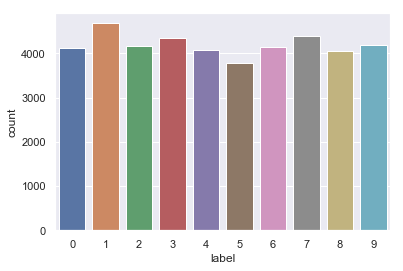

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="darkgrid")
proportionsAx = sns.countplot(x="label", data=trainingDigits)

Looks like all the numbers are represented pretty equally. There are a lot of 1s, though, and not quite as many 5s. Later, when we get predictions, we will see if more training data of a particular number improves that number's recognition. <br/> <br/> Let's get our data prepped.  <br/> <br/> 

In [167]:
X_train = trainingDigits.drop(labels = ["label"], axis=1)
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
y_train = trainingDigits["label"]
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

We can also double-check for missing data here.

In [169]:
print("Presence of missing data on inputs: " + str(X_train.isnull().values.any()) + "\nPresence of missing data on targets: " + str(y_train.isnull().values.any()))

Presence of missing data on inputs: False
Presence of missing data on targets: False


Then we will use matplotlib and some data manipulation to convert each row into a list of 28x28 matrices of pixel data (much more easily read). 

In [180]:
import numpy as np
X_trainShaped = X_train.values.reshape(-1,28,28,1)
X_trainShaped.shape

(42000, 28, 28, 1)

Perfect. These newly created arrays are actually natively compatible with imshow offered by matplotlib. Using some sublots and a bit of iteration, we can regenerate a portion of the data as images to see exactly what we're working with. <br/> <br/>

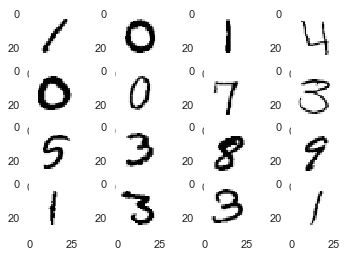

In [177]:
plt.rcParams["axes.grid"] #remove gridlines
fig, ax = plt.subplots(nrows=4, ncols=4)
index = 0
for row in ax:
    for col in row:
        col.imshow(X_trainShaped[index][:,:,0], cmap="Greys")
        index += 1

Notice the numbers (generated left to right top to bottom) match the "label" portion of the data. This means we are on track.

In [178]:
y_train[:16]

0     1
1     0
2     1
3     4
4     0
5     0
6     7
7     3
8     5
9     3
10    8
11    9
12    1
13    3
14    3
15    1
Name: label, dtype: int64

As it stands, the target numbers are stored as 0-9, but this is technically categorical data. To make the data more readable, we use a process called one hot encoding, which transforms the categories (of which there are 10) into a 1x10 matrix where each target has a single 1 in it corresponding to which number it is. Encoding the number 0 looks like this:  <br/> <br/> [1,0,0,0,0,0,0,0,0,0]  <br/> <br/> The number 1 looks like: <br/> <br/> [0,1,0,0,0,0,0,0,0,0] <br/> <br/> And so on for each piece of data in the "label" column. <br/> <br/> The reason we do this isn't as obvious here, but it's more obvious when you use text based categories. If a sample target was classifying cars, and Honda Civic was 1, Mini Cooper was 2, and a Punchbuggy was 3, the network may incorrectly build the idea that a Civic is closer to a Cooper than a Punchbuggy. One hot encoding the data ensures that the related nature of the data is preserved, but not the numerical aspects. <br/> <br/> Below the data is encoded. Keras is a very powerful library for deep learning which runs on top of TensorFlow. to_categorical() is a utility function that automatically encodes the data provided a target dataset and the amount of categories.

In [ ]:
from keras.utils import to_categorical
y_trainEncoded = to_categorical(y_train, num_classes = 10)